There are lots of applications of text classification in the commercial world. For example, news stories are typically organized by topics; content or products are often tagged by categories; users can be classified into cohorts based on how they talk about a product or brand online …
Today we want to rate the way customers talk about an app by analysing the reviews on social network where you don't have that kind of informations. 
We use Python and Jupyter Notebook to develop our system, relying on Scikit-Learn for the machine learning components.

### Problem Formulation

The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.

When a tweet, or any review on social network comes in, we want to assign it to one of 5 stars for rating. The classifier makes the assumption that each tweet is assigned to one and only one category. This is multi-class text classification problem. We will be using the reviews from google store, apple store and trustpilot to train the model. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
df = "data/reviews_tgtg.pkl" #path to be written

with open(df, 'rb') as f:
  df = pickle.load(f)

df.head(5)

,review_content,rating,date,source,preprocessed_review
0,It does exactly what it says it does efficient...,5,2021-12-11 08:03:30,Google,"[exactli, say, effici, save, food, fill, belli..."
1,"Well, I've only done 2 different vendors. The ...",4,2021-12-11 04:56:39,Google,"[well, done, differ, vendor, first, donut, sho..."
2,Still in my first week. And I'm looking forwar...,5,2021-12-11 03:23:46,Google,"[still, first, week, look, forward, great, dea..."
3,loving the app.,5,2021-12-10 22:52:33,Google,"[love, app]"
4,AT FIRST: 1) Lovely experience. charming staff...,2,2021-12-10 22:22:27,Google,"[first, love, experi, charm, staff, moder, hi,..."


In [23]:
df.iloc[:,0]

0       It does exactly what it says it does efficient...
1       Well, I've only done 2 different vendors. The ...
2       Still in my first week. And I'm looking forwar...
3                                         loving the app.
4       AT FIRST: 1) Lovely experience. charming staff...
                              ...                        
1454    Good bag of selection of breads Would have pre...
1461    First try of TGTG at Moshimo Brighton I'd been...
1464    exactly as stated ordered food with app, picke...
1465    Great food I really enjoyed the food I got at ...
1467    Too Good To Go Really great idea, and company ...
Name: review_content, Length: 22968, dtype: object

In [5]:
df_test1 = df[['review_content','rating']]

In [6]:
def label_rating (row):
    if row['rating'] == 1 :
        return 'awful'
    if row['rating'] == 2 :
        return 'bad'
    if row['rating'] == 3 :
        return 'neutral'
    if row['rating'] == 4 :
        return 'good'
    if row['rating'] == 5 :
        return 'awesome'
    return 'Other'


In [7]:
df.apply (lambda row: label_rating(row), axis=1)

0       awesome
1          good
2       awesome
3       awesome
4           bad
         ...   
1454       good
1461    awesome
1464    awesome
1465    awesome
1467    awesome
Length: 22968, dtype: object

In [8]:
df_test1['rating_label'] = df_test1.apply (lambda row: label_rating(row), axis=1)
df_test1

/tmp/ipykernel_6684/3113355612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['rating_label'] = df_test1.apply (lambda row: label_rating(row), axis=1)


,review_content,rating,rating_label
0,It does exactly what it says it does efficient...,5,awesome
1,"Well, I've only done 2 different vendors. The ...",4,good
2,Still in my first week. And I'm looking forwar...,5,awesome
3,loving the app.,5,awesome
4,AT FIRST: 1) Lovely experience. charming staff...,2,bad
...,...,...,...
1454,Good bag of selection of breads Would have pre...,4,good
1461,First try of TGTG at Moshimo Brighton I'd been...,5,awesome
1464,"exactly as stated ordered food with app, picke...",5,awesome
1465,Great food I really enjoyed the food I got at ...,5,awesome


In [9]:
rating_df = df_test1[['rating_label', 'rating']].drop_duplicates().sort_values('rating')
ratinglabel_to_id = dict(rating_df.values)
id_to_ratinglabel = dict(rating_df[['rating', 'rating_label']].values)

In [10]:
ratinglabel_to_id 

{'awful': 1, 'bad': 2, 'neutral': 3, 'good': 4, 'awesome': 5}

### Imbalanced Classes

We see that the number of reviews per rating is imbalanced. The target is extremely unbalanced, which is a parameter to take into account when deploying an algorithm.

In [11]:
df_test1['rating_label'].value_counts()

awesome    17887
awful       1971
good        1689
neutral      824
bad          597
Name: rating_label, dtype: int64

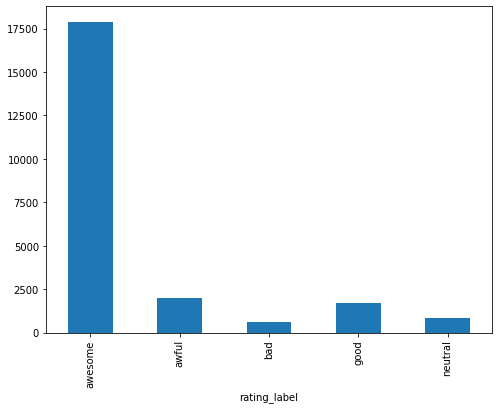

In [12]:
fig = plt.figure(figsize=(8,6))
df_test1.groupby('rating_label').review_content.count().plot.bar(ylim=0)
plt.show()

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. We might need to configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

In [13]:
df_test2 = df[['review_content','rating']]

def label_rating2 (row):
    if row['rating'] == 1 :
        return 'bad'
    if row['rating'] == 2 :
        return 'bad'
    if row['rating'] == 3 :
        return 'neutral'
    if row['rating'] == 4 :
        return 'good'
    if row['rating'] == 5 :
        return 'good'
    return 'Other'

df_test2['rating_label'] = df_test2.apply (lambda row: label_rating2(row), axis=1)
df_test2

/tmp/ipykernel_6684/3424616214.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2['rating_label'] = df_test2.apply (lambda row: label_rating2(row), axis=1)


,review_content,rating,rating_label
0,It does exactly what it says it does efficient...,5,good
1,"Well, I've only done 2 different vendors. The ...",4,good
2,Still in my first week. And I'm looking forwar...,5,good
3,loving the app.,5,good
4,AT FIRST: 1) Lovely experience. charming staff...,2,bad
...,...,...,...
1454,Good bag of selection of breads Would have pre...,4,good
1461,First try of TGTG at Moshimo Brighton I'd been...,5,good
1464,"exactly as stated ordered food with app, picke...",5,good
1465,Great food I really enjoyed the food I got at ...,5,good


In [14]:
df_test2['rating_label'].value_counts()

good       19576
bad         2568
neutral      824
Name: rating_label, dtype: int64

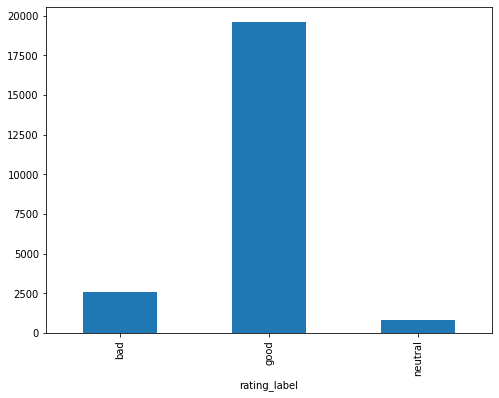

In [16]:
fig = plt.figure(figsize=(8,6))
df_test2.groupby('rating_label').review_content.count().plot.bar(ylim=0)
plt.show()

### Text Representation

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:

    sublinear_df is set to True to use a logarithmic form for frequency.
    min_df is the minimum numbers of documents a word must be present in to be kept.
    norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
    ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
    stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_test1['review_content']).toarray()
labels = df_test1['rating']
features.shape

(22968, 8728)

Now, each of 22968 consumer reviews narratives is represented by 8728 features, representing the tf-idf score for different unigrams and bigrams.

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the rating_label:

In [12]:
N = 2
for rating_label, rating in sorted(ratinglabel_to_id.items()):
    features_chi2 = chi2(features, labels == rating)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(rating_label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'awesome':
  . Most correlated unigrams:
. sold
. available
  . Most correlated bigrams:
. doesn work
. waste time
# 'awful':
  . Most correlated unigrams:
. useless
. rubbish
  . Most correlated bigrams:
. time money
. waste time
# 'bad':
  . Most correlated unigrams:
. explanation
. sucks
  . Most correlated bigrams:
. needs lot
. nice idea
# 'good':
  . Most correlated unigrams:
. notifications
. search
  . Most correlated bigrams:
. need stores
. sort time
# 'neutral':
  . Most correlated unigrams:
. okay
. option
  . Most correlated bigrams:
. idea area
. mixed experience


### Multi-Class Classifier: Features and Design

    To train supervised classifiers, we first transformed the “review_content” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
    After having this vector representations of the text we can train supervised classifiers to train unseen “review_content” and predict the “rating” on which they fall.

After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

    Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [13]:


X_train, X_test, y_train, y_test = train_test_split(df_test1['review_content'], df_test1['rating'], random_state = 0)

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(bow)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(vectorizer.transform(["It's a real mix. The app works well, for sure. A little glitchy at times, but better than many sustainability businesses that try to make an app. Here's the details. (1) no way to tell if a meal will be a good amount of food or two pastries. (2) the app employees are very eager about signing up restaurants: some restaurants have no idea that they are signed up for the service. (3) many businesses are abusing the service to just sell stuff near retail prices: e.g. $8 for a couple pastries."])))

[5]


### Model Selection

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following five models:

    Logistic Regression
    (Multinomial) Naive Bayes
    Linear Support Vector Machine
    Random Forest
    K-Nearest Neighbor (KNN)

/home/roxane/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/roxane/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

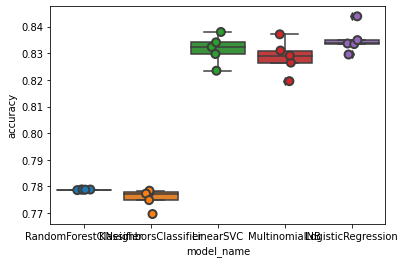

In [15]:

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    KNeighborsClassifier(n_neighbors = 5),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5 #nb of model
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.775601
LinearSVC                 0.831548
LogisticRegression        0.835119
MultinomialNB             0.828675
RandomForestClassifier    0.778779
Name: accuracy, dtype: float64

### Model Evaluation

Continue with our best model (LinearSVC or Logistic Regression), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

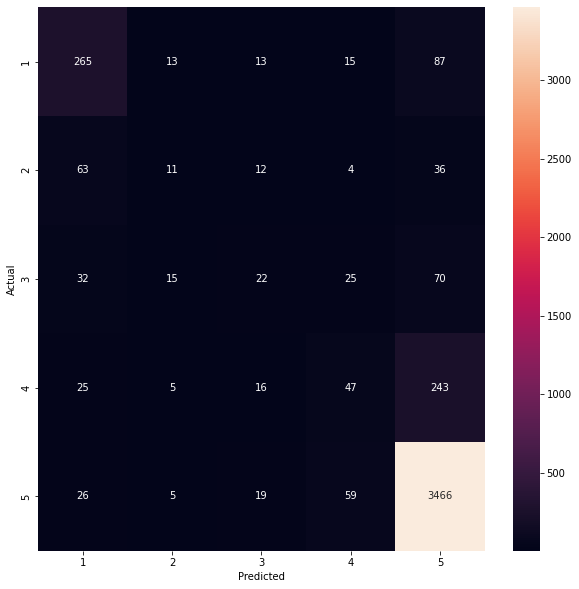

In [30]:
model = LinearSVC() #LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rating_df['rating'].values, yticklabels=rating_df['rating'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
#from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.67      0.66       393
           2       0.22      0.09      0.13       126
           3       0.27      0.13      0.18       164
           4       0.31      0.14      0.19       336
           5       0.89      0.97      0.93      3575

    accuracy                           0.83      4594
   macro avg       0.47      0.40      0.42      4594
weighted avg       0.79      0.83      0.80      4594



/home/roxane/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


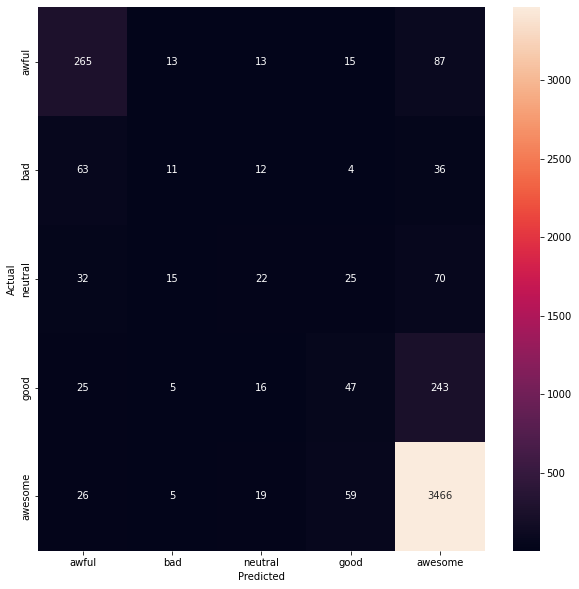

In [32]:
model2 = LogisticRegression()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_test1.index, test_size=0.2, random_state=0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rating_df['rating_label'].values, yticklabels=rating_df['rating_label'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [34]:
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.65      0.67      0.66       393
           2       0.60      0.02      0.05       126
           3       0.18      0.02      0.04       164
           4       0.31      0.08      0.13       336
           5       0.87      0.99      0.92      3575

    accuracy                           0.83      4594
   macro avg       0.52      0.36      0.36      4594
weighted avg       0.77      0.83      0.79      4594

